In [1]:
# modules importation
from trends_functions import *
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# computation parameters
params = get_params()

In [81]:
# run observations
# 'ang4487aer' 'od550aer' 'od550gt1aer' 'od550lt1aer' 'concpm10' 'concpm25' 'concso4' 'scatc550dryaer' 'absc550aer'
var = 'od550aer'
params['kind'] = 'obs'
fill_params(params, var)
params['period'] = '1850-2018'
params['var'] = var
obs_source = params['source']
params['min_dobs']=0 #300
reader = pya.io.ReadUngridded(obs_source)
obs_data = reader.read(vars_to_retrieve=var)

In [82]:
_, OBS_MAP, OBS_DF = process_trend(
    obs_data, params,
    plot=False, show_plot=False, save_plot=False, write_json=False
)

no flags
no flags EUROPE station:  ZvenigoroddsEi_GCWD
no flags ASIA station:  Zhongshan_UnivityDh
no flags NAMERICA station:  Yumaowknife_AuroraC
no flags SAMERICA station:  Veracruz_MAX_MEXFOP
no flags NAFRICA station:  Zinder_DMNporttutea
region:  SAFRICA station:  Walvis_Bay_airport
Less than 7 points in selected period
no flags
no flags AUSTRALIA station:  Tinga_Tinganand_QLD


In [61]:
MOD_MAP, MOD_DF = {}, {}

# run models
#'GFDL-AM4-amip_HIST' if var == 'od550lt1aer' || var == 'od550gt1aer' || 
mod_var = var
params['kind'] = 'mod'

all_mods = list(get_all_mods().keys())

#for the models, set mon_dim to zero
params['min_dim'] = 0
#params['min_ntrend'] = 4
mod_var = params['mod_var']

#mod_sources = sources[var]
mod_sources = params['models']

for mod_source in mod_sources:
    params['source'] = mod_source
    
    #check if model in cache
    fn = 'cache/'+mod_source+'_'+var+'.pkl'
    if os.path.isfile(fn):
        print(mod_source,'use pickle')
        # for reading also binary mode is important 
        pklfile = open(fn, 'rb')      
        mod_data = pickle.load(pklfile) 
        pklfile.close()
    else:
        print(mod_source,'read netcdf data')
        reader = pya.io.ReadGridded(mod_source)
        if (var=='scatc550dryaer'):
            mod_data = reader.read_var(mod_var, ts_type='daily', aux_fun=pya.io.aux_read_cubes.subtract_cubes, aux_vars=['ec550dryaer', 'absc550aer'])
        else:
            mod_data = reader.read_var(mod_var, ts_type='daily')
        
        #if cube has 4 dimensions, extract first level
        if mod_var in ['concso4', 'concpm10', 'concpm25', 'scatc550dryaer', 'absc550aer'] and len(np.shape(mod_data))==4:
            print('cube has 4 dimension, extract first layer')
            mod_data = mod_data.extract_surface_level()
        
        mod_data = mod_data.resample_time(to_ts_type='monthly')

        #write picke file in cache directory
        pklfile = open(fn, 'ab') 

        try:
            # source, destination 
            pickle.dump(mod_data, pklfile)                      
            pklfile.close()
        except AttributeError:
            print('AttributeError')
            os.remove(fn)

    if type(mod_data)==float:
        MOD_MAP[mod_source] = {}
    else:
        #crop the cube to interest period, so can handle WORLD region
        mod_data = mod_data.crop(time_range=(params['period'].split('-')[0], str(int(params['period'].split('-')[1])+1)))
        #check time frequency, if 5 years, set #params['min_ntrend'] = 0
        years = [ts.item().year for ts in mod_data.time_stamps()]
        uyears = np.unique(years)
        i2000 = np.argmin(abs(uyears-2000))
        dy = uyears[i2000+1]-uyears[i2000]
        if dy>1:
            params['min_ntrend'] = 4
        else:
            params['min_ntrend'] = 7
        
        #full colocation
        _, MOD_MAP[mod_source], MOD_DF[mod_source], = process_trend(
            mod_data, params, obs=obs_data,
            colocate_time=False, colocate_space=False,
            OBS_DF = OBS_DF,
            plot=False, show_plot=False, save_plot=False, write_json=False
        )

ECMWF_CAMS_REAN use pickle
OsloCTM3v1.01-met2010_AP3-HIST use pickle
NorESM2-CPL-NEWTEST_HIST use pickle
GFDL-AM4-amip_HIST use pickle
CanESM5_historical use pickle
CESM2_historical use pickle
IPSL-CM6A-LR_historical use pickle
GEOS-i33p2_HIST use pickle
ECHAM6.3-HAM2.3-fSST_HIST use pickle
BCC-CUACE_AP3-HIST use pickle


FileNotFoundError: [Errno 2] No such file or directory: b'/lustre/storeA/project/aerocom/aerocom-users-database/AEROCOM-PHASE-III-2019/BCC-CUACE_AP3-HIST/renamed/aerocom3_BCC-CUACE_HIST_od550aer_Surface_1850_monthly.nc'

In [18]:
sns.set()
sns.set_context("paper")
sns.color_palette("muted")

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

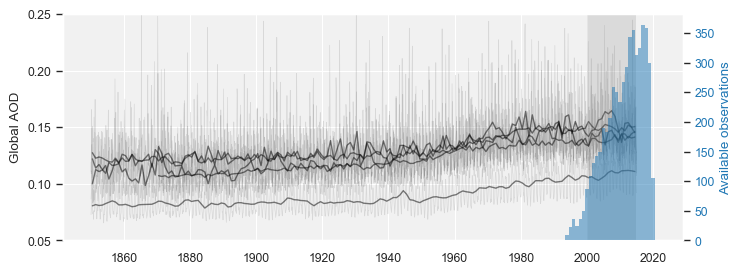

In [136]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=100, facecolor='w', edgecolor='k')
models = list(MOD_MAP.keys())
for model in models:
    
    #monthly values
    mx = js2date(MOD_MAP[model]['WORLD']['trends']['monthly']['jsdate'])
    my = MOD_MAP[model]['WORLD']['trends']['monthly']['data']
    #yealry values
    yx = js2date(MOD_MAP[model]['WORLD']['trends']['yearly']['jsdate'])
    yy = MOD_MAP[model]['WORLD']['trends']['yearly']['data']
    
    if yx[0]<datetime.datetime(1900, 1, 1, 1, 0):
        color = 'black' #get_color2_mod(model)
        plt.plot(mx, my, color=color, lw=0.5, alpha=.1, zorder=3)
        plt.plot(yx, yy, color=color, label=get_all_mods()[model]['name'], lw=1, alpha=.5, zorder=5)

plt.ylabel('Global AOD')
ax.set_ylim(0.05,0.25)
#setbackground color
ax.set_facecolor('#F1F1F1')
ax.yaxis.set_ticks(np.arange(0.05, 0.30, 0.05))

#available observations
nobs = OBS_DF['WORLD'].groupby(pd.Grouper(freq='A')).mean().count(axis=1)
ox = nobs.index
oy = nobs.values
#set new axis
ax2 = ax.twinx()
color = 'tab:blue'
ax2.set_ylabel('Available observations', color=color)  # we already handled the x-label with ax1
ax2.bar(ox, oy, width=1, color=color, alpha=.5, linewidth=0, zorder=4)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False)

#highlight study period
plt.axvspan(datetime.datetime(2000, 1, 1, 1, 0),datetime.datetime(2015, 1, 1, 1, 0), facecolor='gray', alpha=0.2, zorder=0, linewidth=0, edgecolor='white')

fx=.5
fig.set_size_inches(16*fx,6*fx)
plt.savefig('figs/hist_runs.png', dpi=300, bbox_inches='tight')